In [1]:
import keras
import tensorflow as tf

In [2]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob
from keras_unet.models import custom_unet, satellite_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import plot_segm_history

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
# training data subset original for first 60
base_dirO = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\data_256\train')
mask_dirO = base_dirO.joinpath('80s_mask')
train_image_dirO = mask_dirO.joinpath('u_train_reproject')
trees_mask_dirO = mask_dirO.joinpath('trees')
building_mask_dirO = mask_dirO.joinpath('building')
pavement_mask_dirO = mask_dirO.joinpath('pavement')

In [4]:
os.listdir(mask_dirO)

['building', 'desktop.ini', 'pavement', 'trees', 'u_train_reproject']

In [5]:
def make_path(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}_{number}.tif")

In [6]:
def img_number(fpath: str) -> int:
    return int(os.path.splitext(os.path.split(fpath)[1])[0].split('_')[-1])

In [7]:
# crop image at pixel 75 x 75 (ignoring NA extent created by reprojection)
def load_image_large(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()[81:209,81:209]

In [8]:
209-81

128

In [9]:
def sorted_paths(img_dir: Path):
    return sorted(glob(img_dir.joinpath('*.tif').as_posix()), key=img_number)

In [10]:
def load_stack_safely_large(shape, dtype, img_dir, prefix):
    """
    Load a stack of images from disk into an ndarray.

    Performs the load potentially several times, to ensure that values
    stabilize. Google seems to be...tricky...
    """
    last_sum = 0
    while True:
        stack = np.zeros(shape=shape, dtype=dtype)
        for i in range(shape[0]):
            image_path = make_path(img_dir, prefix, i + 1)
            if not os.path.isfile(image_path):
                print("skipping", image_path)
                continue
            stack[i, :, :] = load_image_large(image_path)
        if stack.sum() == last_sum:
            break
        last_sum = stack.sum()
    return stack

In [11]:
I, N, M = 60, 128, 128

In [12]:
train_imagesO = load_stack_safely_large((I, N, M), np.float32, train_image_dirO, "wgs_train")
tree_masksO = load_stack_safely_large((I, N, M), np.int8, trees_mask_dirO, "tree_mask")
building_masksO = load_stack_safely_large((I, N, M), np.int8, building_mask_dirO, "building_mask")
pavement_masksO = load_stack_safely_large((I, N, M), np.int8, pavement_mask_dirO, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\trees\tree_mask_13.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\trees\tree_mask_22.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\trees\tree_mask_41.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\trees\tree_mask_13.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\trees\tree_mask_22.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\trees\tree_mask_41.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\building\building_mask_1.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\building\building_mask_8.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\bui

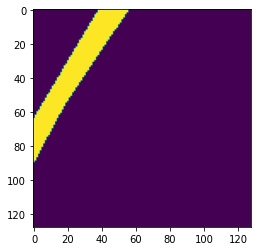

In [13]:
plt.imshow(pavement_masksO[5,:,:])

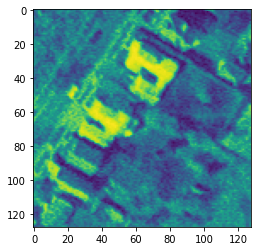

In [14]:
plt.imshow(train_imagesO[5,:,:])

In [15]:
# Use small traced images for last 40
base_dirS = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\data_128\train')
mask_dirS = base_dirS.joinpath('mask')
train_image_dirS = mask_dirS.joinpath('u_train_reproject')
trees_mask_dirS = mask_dirS.joinpath('trees')
building_mask_dirS = mask_dirS.joinpath('building')
pavement_mask_dirS = mask_dirS.joinpath('pavement')

In [16]:
def load_image_small(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()[7:-7,5:-5]

In [17]:
test = load_image_small(r'e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\u_train_reproject\wgs_train_40.tif')

In [18]:
test2 = load_image_small(r'e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_1.tif')

In [19]:
test2.shape

(128, 128)

In [20]:
test.shape

(128, 128)

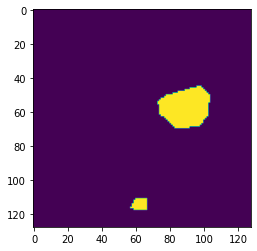

In [21]:
plt.imshow(test2)

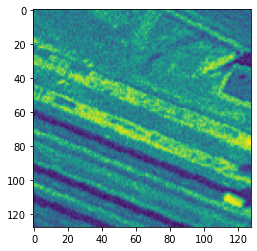

In [22]:
plt.imshow(test)

In [23]:
test.shape

(128, 128)

In [24]:
def load_stack_safely_small(shape, dtype, img_dir, prefix):
    """
    Load a stack of images from disk into an ndarray.

    Performs the load potentially several times, to ensure that values
    stabilize. Google seems to be...tricky...
    """
    last_sum = 0
    while True:
        stack = np.zeros(shape=shape, dtype=dtype)
        for i in range(shape[0]):
            image_path = make_path(img_dir, prefix, i + 1 )
            if not os.path.isfile(image_path):
                print("skipping", image_path)
                continue
            stack[i, :, :] = load_image_small(image_path)
        if stack.sum() == last_sum:
            break
        last_sum = stack.sum()
    return stack

In [26]:
K, N, M = 40, 128, 128
train_imagesS = load_stack_safely_small((K, N, M), np.float32, train_image_dirS, "wgs_train")
tree_masksS = load_stack_safely_small((K, N, M), np.int8, trees_mask_dirS, "tree_mask")
building_masksS = load_stack_safely_small((K, N, M), np.int8, building_mask_dirS, "building_mask")
pavement_masksS = load_stack_safely_small((K, N, M), np.int8, pavement_mask_dirS, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_2.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_5.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_7.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_9.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_10.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_12.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_14.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_15.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_16.tif
skipping e:\Google Drive\researc

In [29]:
# Use small traced images for last 40
base_dirSt = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\data_strat')
mask_dirSt = base_dirSt.joinpath('mask')
train_image_dirSt = mask_dirSt.joinpath('u_train_reproject')
trees_mask_dirSt = mask_dirSt.joinpath('trees')
building_mask_dirSt = mask_dirSt.joinpath('buildings')
pavement_mask_dirSt = mask_dirSt.joinpath('pavement')

In [30]:
K, N, M = 40, 128, 128
train_imagesSt = load_stack_safely_small((K, N, M), np.float32, train_image_dirSt, "wgs_train")
tree_masksSt = load_stack_safely_small((K, N, M), np.int8, trees_mask_dirSt, "tree_mask")
building_masksSt = load_stack_safely_small((K, N, M), np.int8, building_mask_dirSt, "building_mask")
pavement_masksSt = load_stack_safely_small((K, N, M), np.int8, pavement_mask_dirSt, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\model_save\1980\data_strat\mask\trees\tree_mask_2.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_strat\mask\trees\tree_mask_3.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_strat\mask\trees\tree_mask_5.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_strat\mask\trees\tree_mask_6.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_strat\mask\trees\tree_mask_11.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_strat\mask\trees\tree_mask_12.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_strat\mask\trees\tree_mask_13.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_strat\mask\trees\tree_mask_14.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_strat\mask\trees\tree_mask_18.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\dat

In [31]:
train_images = np.zeros((140,128,128))
tree_masks =  np.zeros((140,128,128))
building_masks =  np.zeros((140,128,128))
pavement_masks =  np.zeros((140,128,128))


In [33]:
train_images[0:60,:,:] = train_imagesO
train_images[60:100,:,:] = train_imagesS
train_images[100:140,:,:] = train_imagesSt

In [34]:
tree_masks[0:60,:,:] = tree_masksO
tree_masks[60:100,:,:] = tree_masksS
tree_masks[100:140,:,:] = tree_masksSt

In [35]:
building_masks[0:60,:,:] = building_masksO
building_masks[60:100,:,:] = building_masksS
building_masks[100:140,:,:] = building_masksSt

In [36]:
pavement_masks[0:60,:,:] = pavement_masksO
pavement_masks[60:100,:,:] = pavement_masksS
pavement_masks[100:140,:,:] = pavement_masksSt

In [37]:

def load_image_no_trim(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()

In [38]:
def load_stack_nt(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape=shape, dtype=dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        stack[i, :, :] = load_image_no_trim(image_path)
    return stack

In [39]:
N,M

(128, 128)

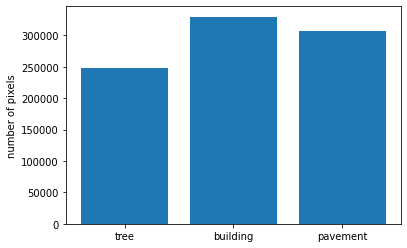

In [40]:
fig, ax = plt.subplots()
ax.bar(range(3), [tree_masks.sum(), building_masks.sum(), pavement_masks.sum()])
ax.set_xticks((0, 1, 2))
ax.set_xticklabels(('tree', 'building', 'pavement'))
plt.ylabel('number of pixels')
plt.show()

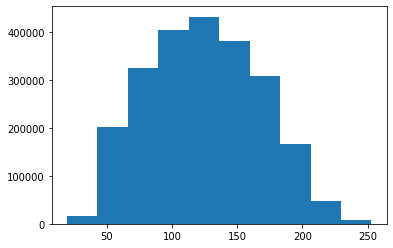

In [41]:
plt.hist(train_images.flatten())
plt.show()

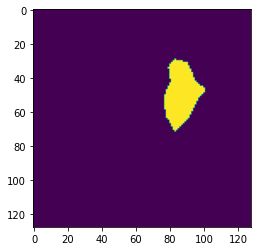

In [45]:
plt.imshow(tree_masks[125,:,:])

In [100]:
model = satellite_unet(
    (N, M, 1),
    3,
    # dropout_type="spatial"
)

In [101]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded],
    
)

In [102]:
W = 140
Y = np.zeros(shape=(W, N, M, 3), dtype=np.int8)
Y[:, :, :, 0] = tree_masks
Y[:, :, :, 1] = building_masks
Y[:, :, :, 2] = pavement_masks

In [103]:
Y.shape, tree_masks.shape

((140, 128, 128, 3), (140, 128, 128))

In [104]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_84 (Conv2D)             (None, 128, 128, 64  640         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 128, 128, 64  256        ['conv2d_84[0][0]']              
 ormalization)                  )                                                           

In [105]:
checkpoint_path = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save')
checkpoint_dir = os.path.dirname(checkpoint_path)

In [106]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [107]:
history = model.fit(
    train_images.reshape(W, N, M, 1),
    Y,
    epochs=110,
          callbacks=[cp_callback])

Epoch 1/110
5/5 [==============================] - ETA: 0s - loss: 0.6116 - iou: 0.1171 - iou_thresholded: 0.1165
Epoch 00001: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 34s 6s/step - loss: 0.6116 - iou: 0.1171 - iou_thresholded: 0.1165
Epoch 2/110
5/5 [==============================] - ETA: 0s - loss: 0.3892 - iou: 0.1072 - iou_thresholded: 0.0534
Epoch 00002: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 27s 5s/step - loss: 0.3892 - iou: 0.1072 - iou_thresholded: 0.0534
Epoch 3/110
5/5 [==============================] - ETA: 0s - loss: 0.3470 - iou: 0.1334 - iou_thresholded: 0.0705
Epoch 00003: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 27s 5s/step - loss: 0.3470 - iou: 0.1334 - iou_thresholded: 0.070

5/5 [==============================] - 27s 5s/step - loss: 0.1880 - iou: 0.3868 - iou_thresholded: 0.4690
Epoch 26/110
5/5 [==============================] - ETA: 0s - loss: 0.1820 - iou: 0.4063 - iou_thresholded: 0.5138
Epoch 00026: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 27s 5s/step - loss: 0.1820 - iou: 0.4063 - iou_thresholded: 0.5138
Epoch 27/110
5/5 [==============================] - ETA: 0s - loss: 0.1799 - iou: 0.4221 - iou_thresholded: 0.5175
Epoch 00027: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 27s 5s/step - loss: 0.1799 - iou: 0.4221 - iou_thresholded: 0.5175
Epoch 28/110
5/5 [==============================] - ETA: 0s - loss: 0.1655 - iou: 0.4327 - iou_thresholded: 0.5403
Epoch 00028: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_

5/5 [==============================] - ETA: 0s - loss: 0.1058 - iou: 0.6367 - iou_thresholded: 0.7052
Epoch 00050: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 27s 5s/step - loss: 0.1058 - iou: 0.6367 - iou_thresholded: 0.7052
Epoch 51/110
5/5 [==============================] - ETA: 0s - loss: 0.0916 - iou: 0.6502 - iou_thresholded: 0.7460
Epoch 00051: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 28s 5s/step - loss: 0.0916 - iou: 0.6502 - iou_thresholded: 0.7460
Epoch 52/110
5/5 [==============================] - ETA: 0s - loss: 0.0973 - iou: 0.6333 - iou_thresholded: 0.7350
Epoch 00052: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 28s 6s/step - loss: 0.0973 - iou: 0.6333 - iou_thresholded: 0.7350
Epoch 53

5/5 [==============================] - 28s 5s/step - loss: 0.0480 - iou: 0.7943 - iou_thresholded: 0.8587
Epoch 75/110
5/5 [==============================] - ETA: 0s - loss: 0.0476 - iou: 0.7908 - iou_thresholded: 0.8528
Epoch 00075: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 28s 5s/step - loss: 0.0476 - iou: 0.7908 - iou_thresholded: 0.8528
Epoch 76/110
5/5 [==============================] - ETA: 0s - loss: 0.0462 - iou: 0.8015 - iou_thresholded: 0.8587
Epoch 00076: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 28s 6s/step - loss: 0.0462 - iou: 0.8015 - iou_thresholded: 0.8587
Epoch 77/110
5/5 [==============================] - ETA: 0s - loss: 0.0422 - iou: 0.8151 - iou_thresholded: 0.8726
Epoch 00077: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_

5/5 [==============================] - ETA: 0s - loss: 0.0744 - iou: 0.7005 - iou_thresholded: 0.7984
Epoch 00099: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 28s 5s/step - loss: 0.0744 - iou: 0.7005 - iou_thresholded: 0.7984
Epoch 100/110
5/5 [==============================] - ETA: 0s - loss: 0.0630 - iou: 0.7398 - iou_thresholded: 0.8246
Epoch 00100: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 28s 5s/step - loss: 0.0630 - iou: 0.7398 - iou_thresholded: 0.8246
Epoch 101/110
5/5 [==============================] - ETA: 0s - loss: 0.0621 - iou: 0.7555 - iou_thresholded: 0.8183
Epoch 00101: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_strat\model_check_save
5/5 [==============================] - 28s 6s/step - loss: 0.0621 - iou: 0.7555 - iou_thresholded: 0.8183
Epoch 

In [125]:
modelsave_path = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\model_strat\saved_model\80small')

In [126]:
modelsave_path

WindowsPath('e:/Google Drive/research/projects/utica/model_save/1980/model_strat/saved_model/80small')

In [127]:
model.save(modelsave_path)

INFO:tensorflow:Assets written to: e:\Google Drive\research\projects\utica\model_save\1980\model_strat\saved_model\80small\assets


In [128]:
Y_pred = model.predict(train_images.reshape(W, N, M, 1))

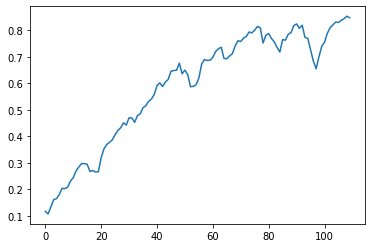

In [110]:
plt.plot(history.history['iou'])

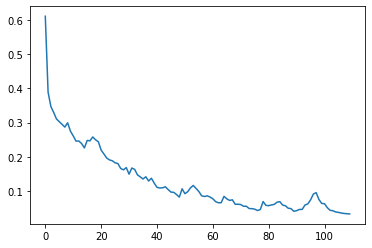

In [111]:
plt.plot(history.history['loss'])

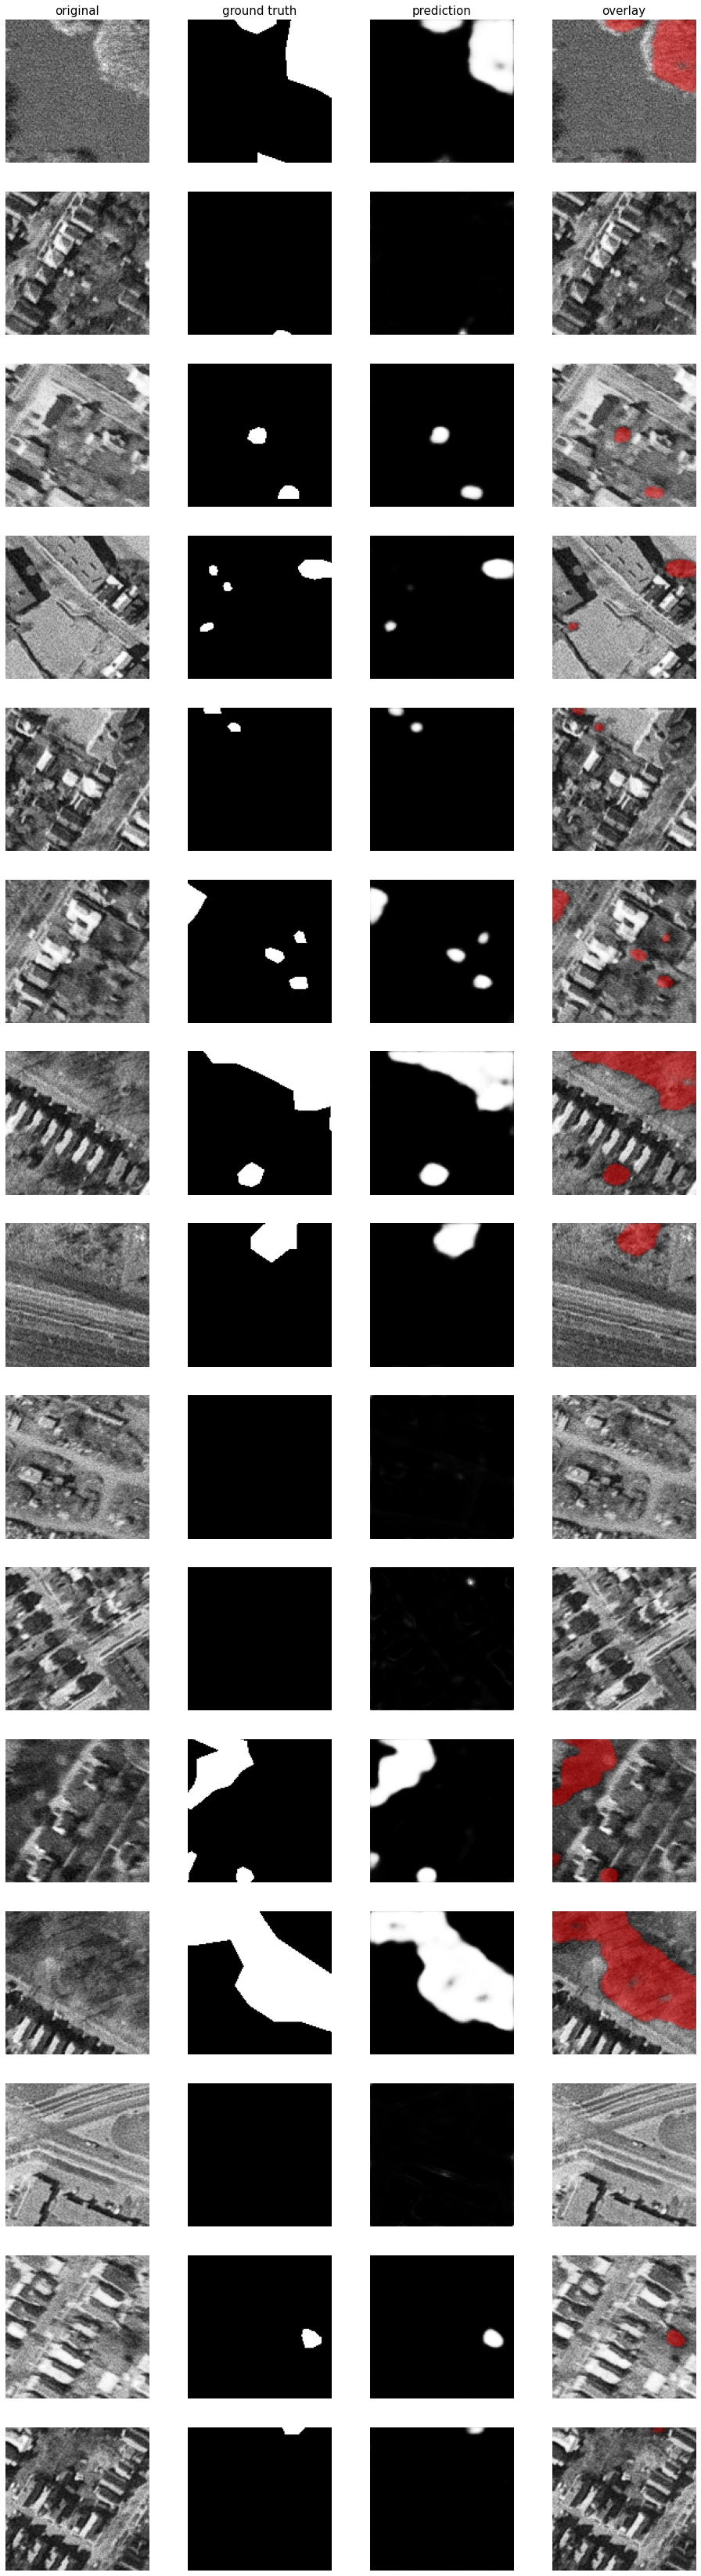

In [112]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(W, N, M, 1), 
    mask_imgs=Y[:, :, :, 0], 
    pred_imgs=Y_pred[:, :, :, 0], 
    nm_img_to_plot=15
  )

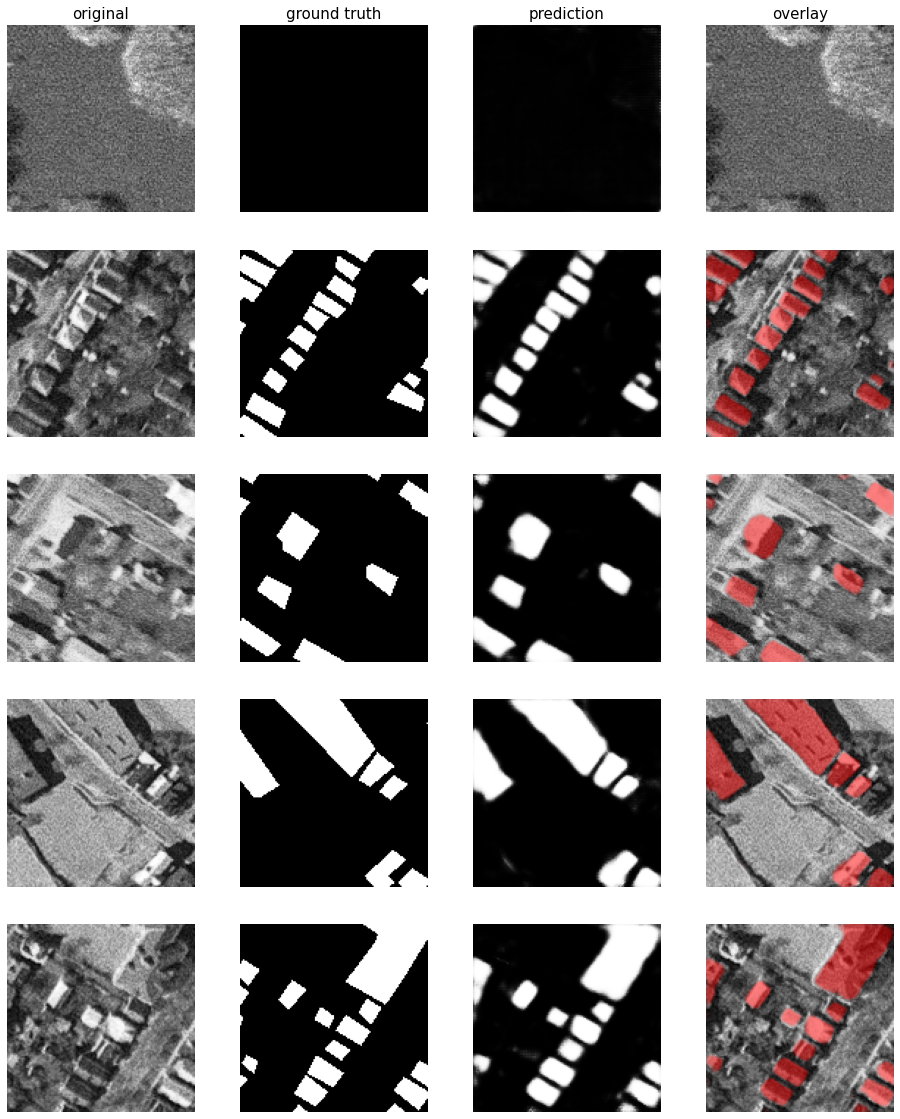

In [113]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(W, N, M, 1), 
    mask_imgs=Y[:, :, :, 1], 
    pred_imgs=Y_pred[:, :, :, 1], 
    nm_img_to_plot=5
  )

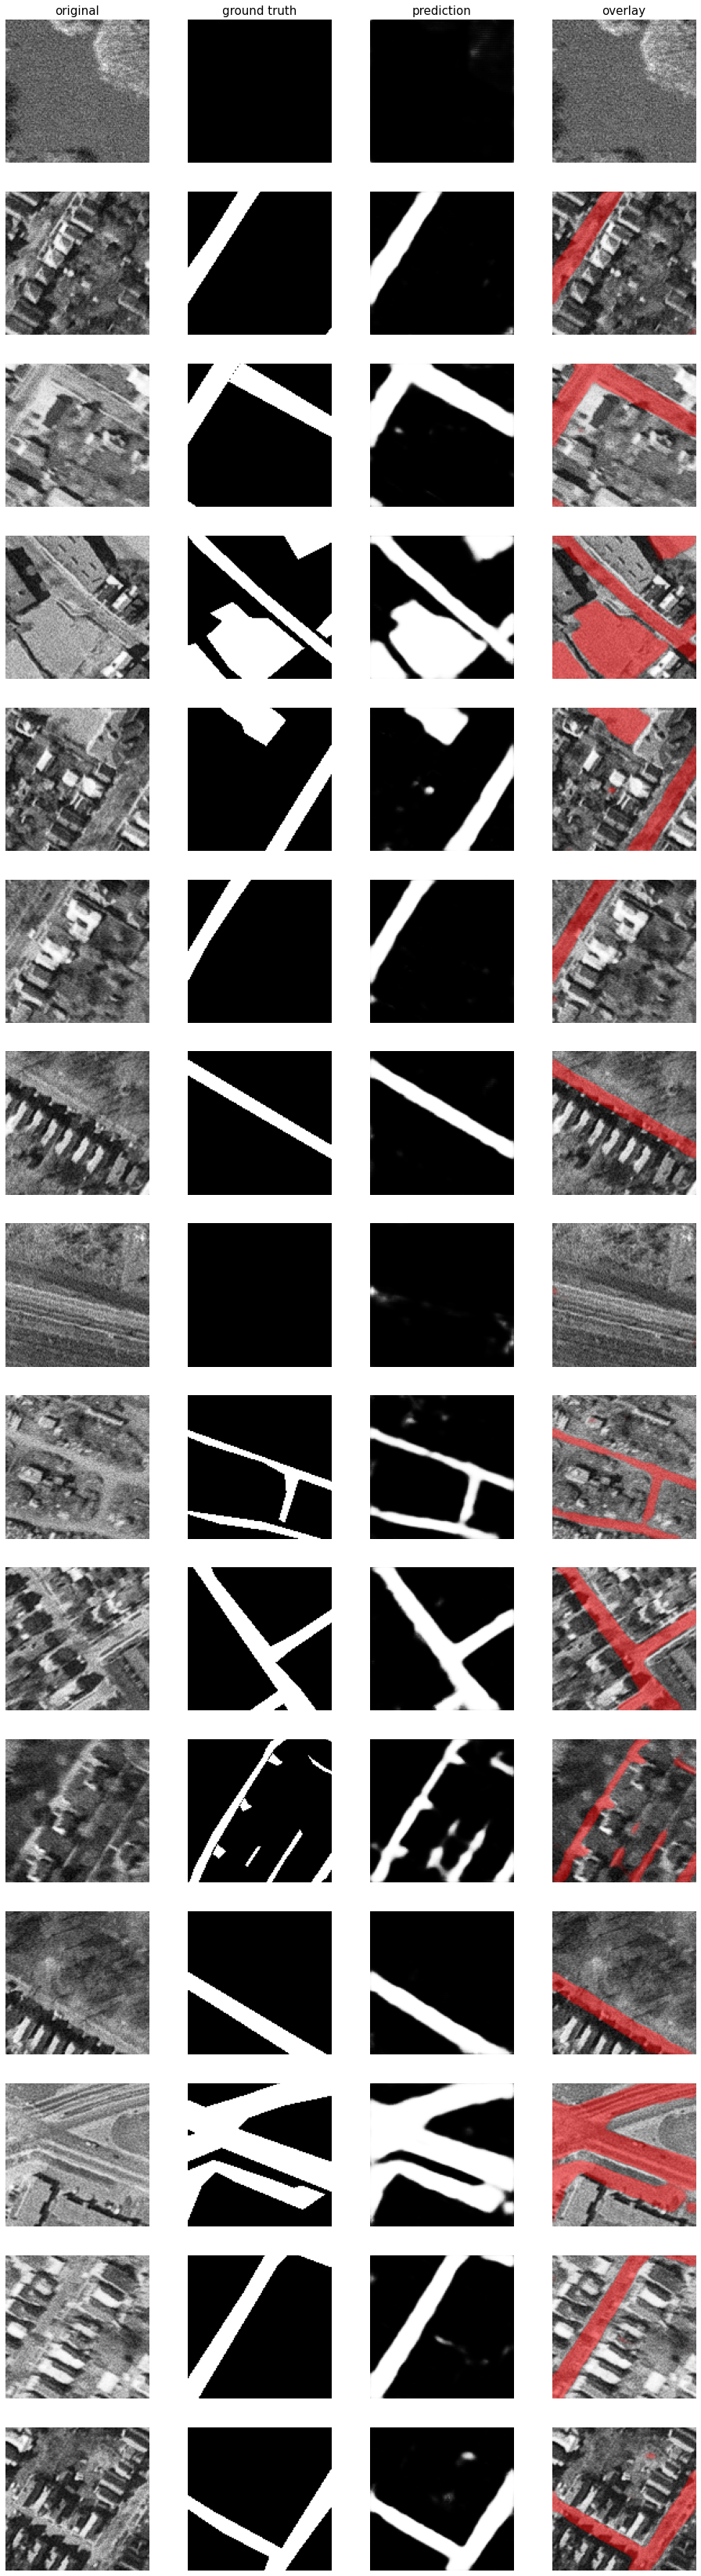

In [114]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(W, N, M, 1), 
    mask_imgs=Y[:, :, :, 2], 
    pred_imgs=Y_pred[:, :, :, 2], 
    nm_img_to_plot=15
  )

In [115]:
# validation data
base_dir = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid')
mask_dirV = base_dir.joinpath('mask_80s_valid')
train_image_dirV = mask_dirV.joinpath('u_valid_reproject')
trees_mask_dirV = mask_dirV.joinpath('trees')
building_mask_dirV = mask_dirV.joinpath('building')
pavement_mask_dirV = mask_dirV.joinpath('pavement')

In [116]:
K = 20

In [117]:
valid_images = load_stack_safely_large((K, N, M), np.float32, train_image_dirV, "wgs_valid")
tree_valid = load_stack_safely_large((K, N, M), np.int8, trees_mask_dirV, "tree_mask")
building_valid = load_stack_safely_large((K, N, M), np.int8, building_mask_dirV, "building_mask")
pavement_valid = load_stack_safely_large((K, N, M), np.int8, pavement_mask_dirV, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_80s_valid\trees\tree_mask_4.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_80s_valid\trees\tree_mask_4.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_80s_valid\building\building_mask_4.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_80s_valid\building\building_mask_10.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_80s_valid\building\building_mask_16.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_80s_valid\building\building_mask_4.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_80s_valid\building\building_mask_10.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_80s_valid\building\building_mask_16.tif
skipping e:\Google

In [118]:
Yvalid = np.zeros(shape=(K, N, M, 3), dtype=np.int8)
Yvalid[:, :, :, 0] = tree_valid
Yvalid[:, :, :, 1] = building_valid
Yvalid[:, :, :, 2] = pavement_valid

In [119]:
Y_valid = model.predict(valid_images.reshape(K, N, M, 1))

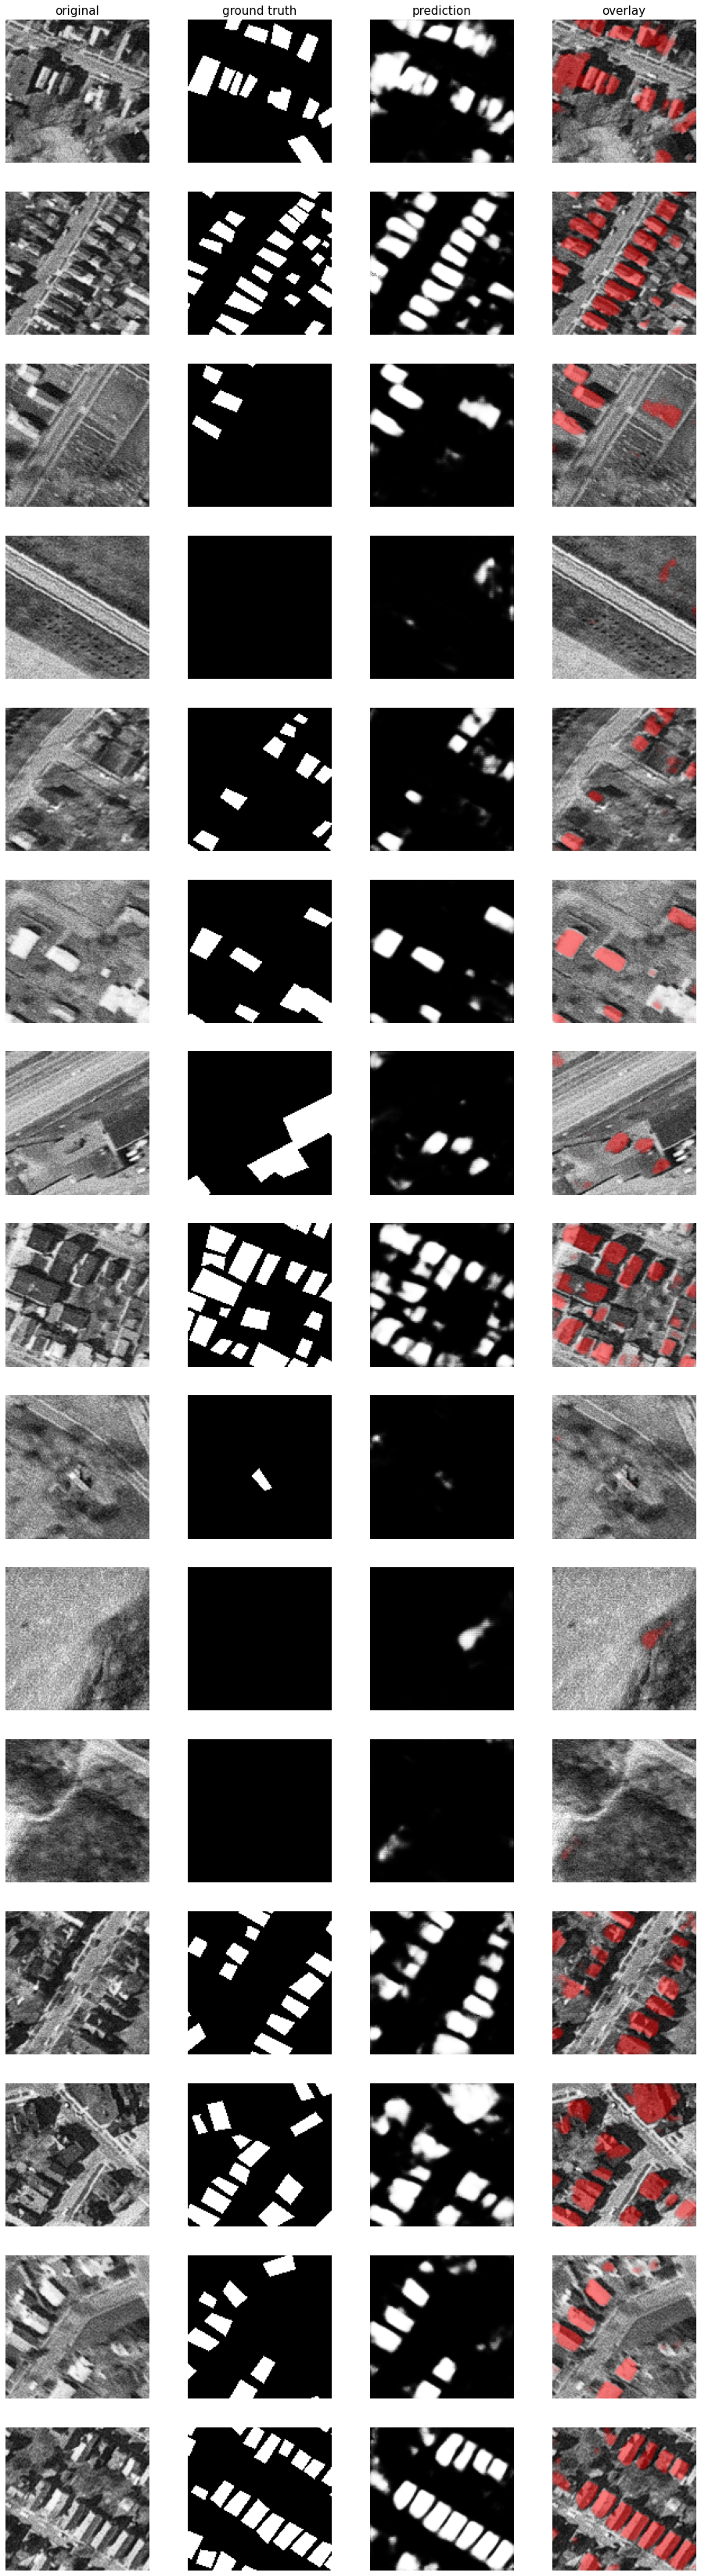

In [120]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 1), 
    mask_imgs=Yvalid[:, :, :, 1], 
    pred_imgs=Y_valid[:, :, :, 1], 
    nm_img_to_plot=15
  )

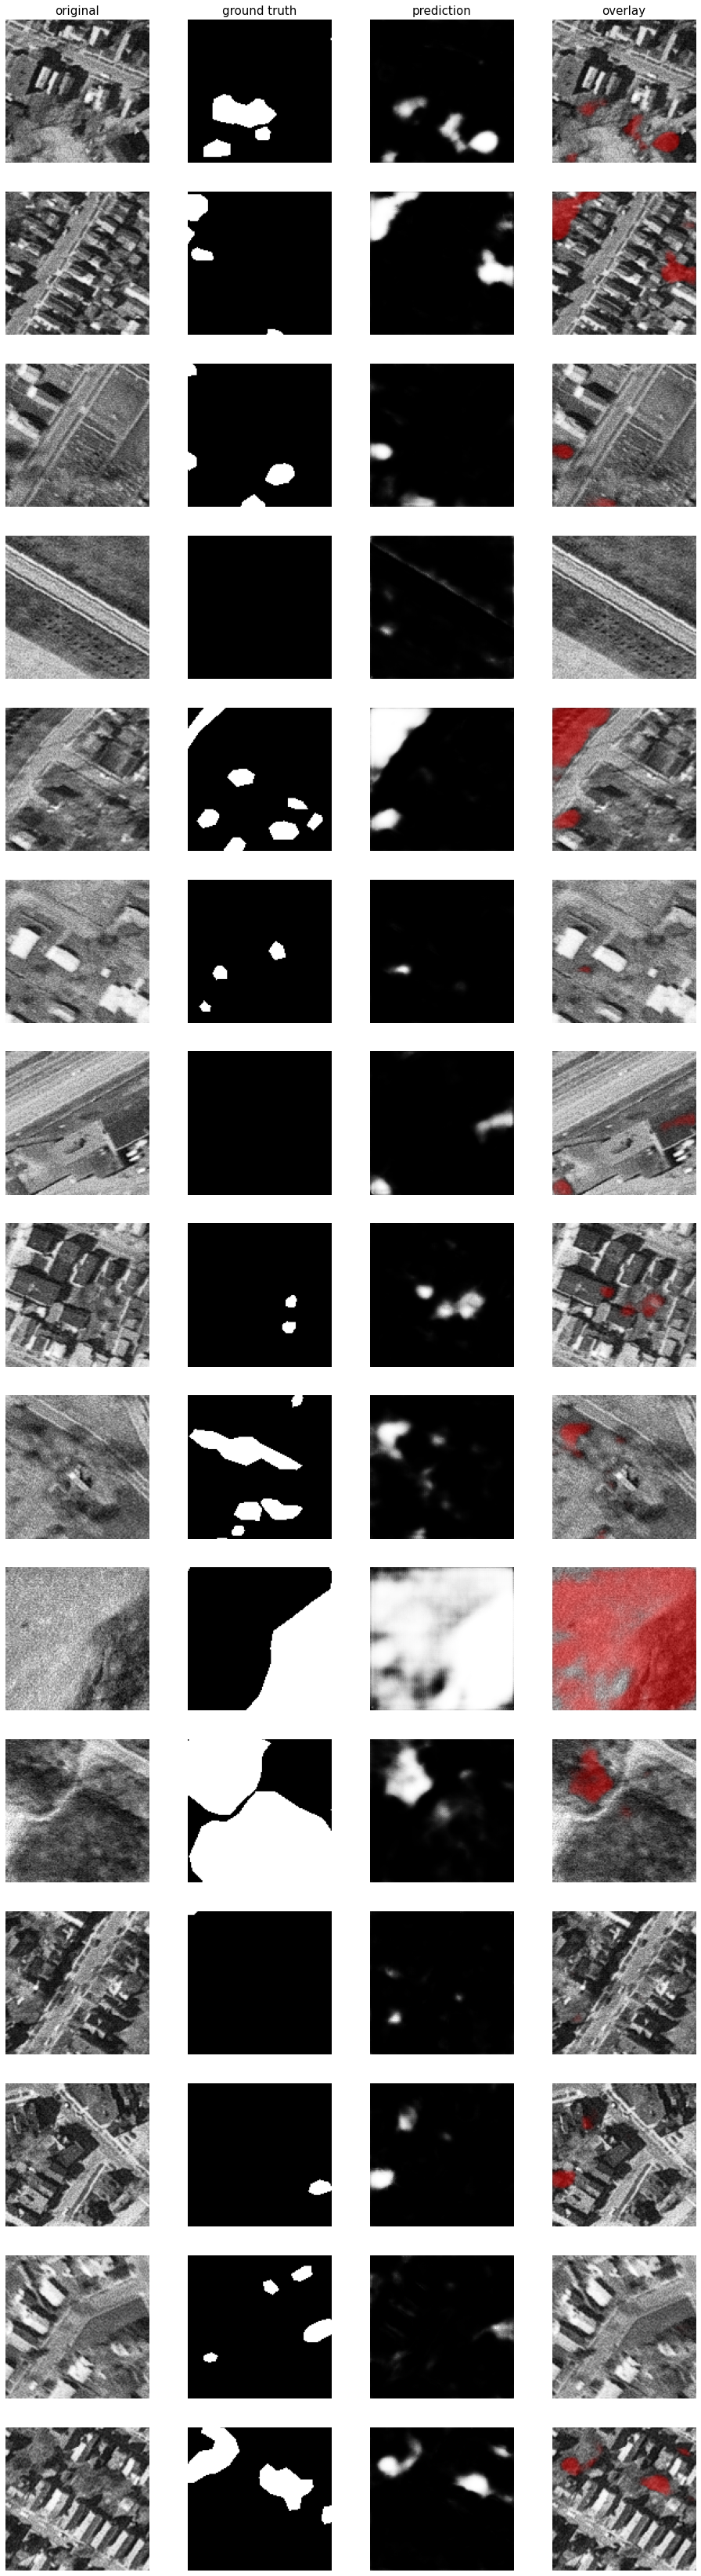

In [98]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 1), 
    mask_imgs=Yvalid[:, :, :, 0], 
    pred_imgs=Y_valid[:, :, :, 0], 
    nm_img_to_plot=15
  )

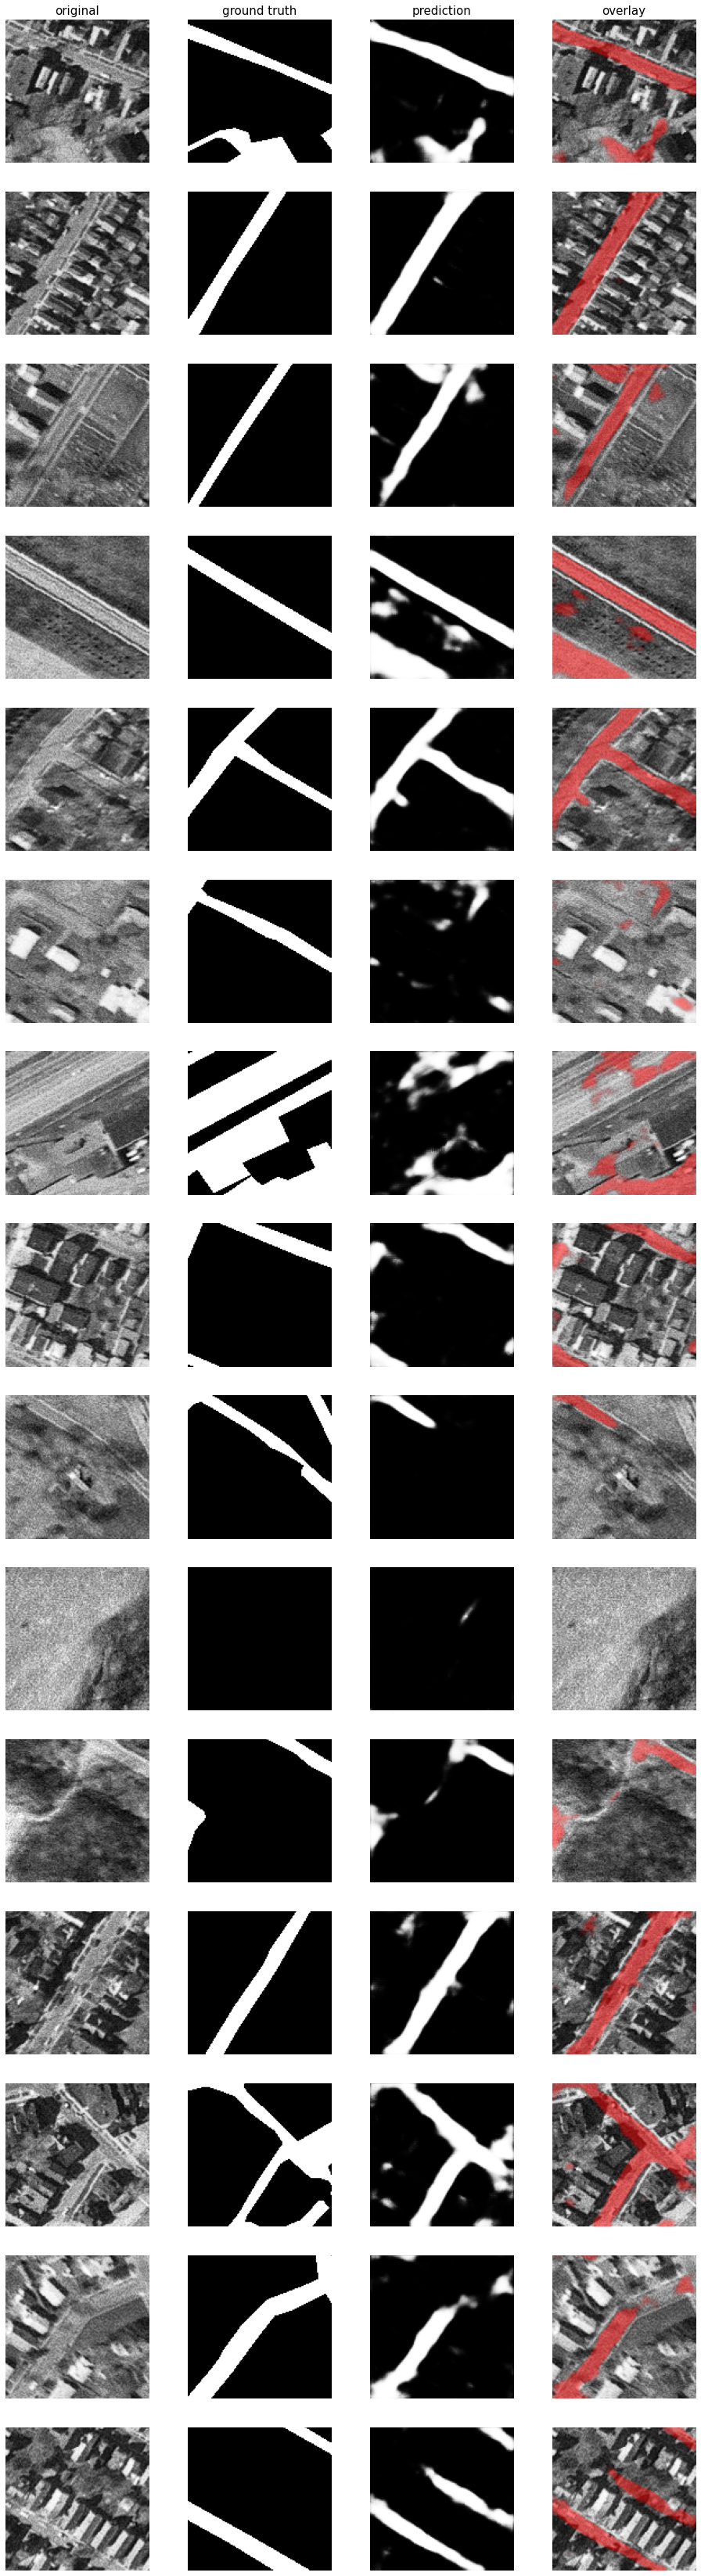

In [121]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 1), 
    mask_imgs=Yvalid[:, :, :, 2], 
    pred_imgs=Y_valid[:, :, :, 2], 
    nm_img_to_plot=15
  )

In [122]:
Y_valid[0,0,0,0]

0.020495534

In [123]:
treePredict = Y_valid[:,:,:,0]

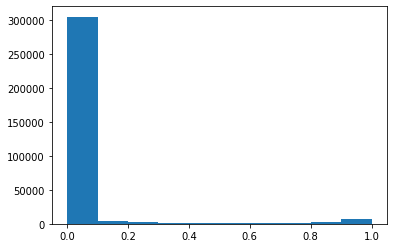

In [124]:
plt.hist(treePredict.flatten())
plt.show()

In [129]:
def load_stack_nt(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape=shape, dtype=dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        stack[i, :, :] = load_image_no_trim(image_path)
    return stack

In [130]:
driver = gdal.GetDriverByName("GTiff")
driver.Register()

2

In [132]:
def save_predict_valid( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTree = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTree.SetGeoTransform(gt)
        outTree.SetProjection(pt)
        outBandTree = outTree.GetRasterBand(1)
        outBandTree.WriteArray(Y_valid[i,:,:,0])
        outBandTree.SetNoDataValue(np.nan)
        outBandTree.FlushCache()
        outBandTree = None
        outTree = None

In [133]:
tree_valid_dir = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\valid\tree'
save_predict_valid(nImg = 20,xdim= 128, ydim= 128,img_dir = tree_valid_dir,prefix = "tree_predict",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [134]:
def save_predict_validB( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        build_ds = gdal.Open(orig_path)
        gt = build_ds.GetGeoTransform()
        pt = build_ds.GetProjection()
        outBuild = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outBuild.SetGeoTransform(gt)
        outBuild.SetProjection(pt)
        outBandBuild = outBuild.GetRasterBand(1)
        outBandBuild.WriteArray(Y_valid[i,:,:,1])
        outBandBuild.SetNoDataValue(np.nan)
        outBandBuild.FlushCache()
        outBandBuild = None
        outBuild = None

In [135]:
build_valid_dir = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\valid\building'
save_predict_validB(nImg = 20,xdim= 128, ydim= 128,img_dir =build_valid_dir,prefix = "building_predict",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [136]:
def save_predict_validP( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        build_ds = gdal.Open(orig_path)
        gt = build_ds.GetGeoTransform()
        pt = build_ds.GetProjection()
        outPave = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outPave.SetGeoTransform(gt)
        outPave.SetProjection(pt)
        outBandPave = outPave.GetRasterBand(1)
        outBandPave.WriteArray(Y_valid[i,:,:,2])
        outBandPave.SetNoDataValue(np.nan)
        outBandPave.FlushCache()
        outBandPave = None
        outPave = None

In [137]:
pave_valid_dir = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\valid\pavement'
save_predict_validP(nImg = 20,xdim= 128, ydim= 128,img_dir =pave_valid_dir,prefix = "pavement_predict",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [138]:
#due to late night coding, mask files where slightly off dimensions. Need to resave files that were cut down here for easier matching.
def save_mask_valid( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Yvalid[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [139]:
train_image_dirV

WindowsPath('e:/Google Drive/research/projects/utica/model_save/1980/data_256/valid/mask_80s_valid/u_valid_reproject')

In [140]:
tree_m_dir = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\crop_valid\tree'
save_mask_valid(nImg = 20,xdim= 128, ydim= 128,img_dir = tree_m_dir, prefix = "tree_mask",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [141]:
def save_mask_validB( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Yvalid[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [142]:
build_m_dir = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\crop_valid\building'
save_mask_validB(nImg = 20,xdim= 128, ydim= 128,img_dir = build_m_dir, prefix = "building_mask",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [143]:
def save_mask_validP( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Yvalid[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [144]:
pave_m_dir = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\crop_valid\pavement'
save_mask_validP(nImg = 20,xdim= 128, ydim= 128,img_dir = pave_m_dir, prefix = "pavement_mask",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [145]:
def save_mask_image( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(valid_images[i, :, :])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [146]:
image_m_dir = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\crop_valid\image'
save_mask_image(nImg = 20,xdim= 128, ydim= 128,img_dir = image_m_dir, prefix = "image",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [147]:
valid_images.shape

(20, 128, 128)

In [148]:
# prediction data
base_dirP = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\img_tile_128\image')

In [149]:
J, N, M = 2574, 128, 128

In [150]:
predict_img = load_stack_nt((J, N, M), np.float32,base_dirP, "predict")

In [151]:
Y_all = model.predict(predict_img.reshape(J, N, M, 1))

In [152]:
# prediction data offset 2 (25 pixels)
base_dirP2 = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\img_tile_128\image_2')
predict_img2 = load_stack_nt((J, N, M), np.float32,base_dirP2, "predict")

In [153]:
Y_all2 = model.predict(predict_img2.reshape(J, N, M, 1))

In [154]:
# prediction data offset 3 (100 pixels)
L, N, M = 2470, 128, 128
base_dirP3 = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\img_tile_128\image_3')
predict_img3 = load_stack_nt((L, N, M), np.float32,base_dirP3, "predict")

In [155]:
Y_all3 = model.predict(predict_img3.reshape(L, N, M, 1))
Y_all3.shape

(2470, 128, 128, 3)

In [156]:
# save map prediction

def save_predict_build( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None


predict_build_dir = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\image\building'
save_predict_build(nImg = 2574,xdim= 128, ydim= 128,img_dir = predict_build_dir, prefix = "building",orig_dir = base_dirP , prefix_orig = "predict")

In [157]:
# save map prediction

def save_predict_build2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all2[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None


predict_build_dir2 = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\image_2\building'
save_predict_build2(nImg = 2574,xdim= 128, ydim= 128,img_dir = predict_build_dir2, prefix = "building",orig_dir = base_dirP2 , prefix_orig = "predict")

In [158]:
# save map prediction

def save_predict_build3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all3[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None


predict_build_dir3 = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\image_3\building'
save_predict_build3(nImg = 2470,xdim= 128, ydim= 128,img_dir = predict_build_dir3, prefix = "building",orig_dir = base_dirP3 , prefix_orig = "predict")

In [159]:
def save_predict_tree( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None
        
predict_tree_dir = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\image\tree'
save_predict_tree(nImg = 2574,xdim= 128, ydim= 128,img_dir = predict_tree_dir, prefix = "tree",orig_dir = base_dirP , prefix_orig = "predict")

In [160]:
def save_predict_tree2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all2[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None
        
predict_tree_dir2 = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\image_2\tree'
save_predict_tree2(nImg = 2574,xdim= 128, ydim= 128,img_dir = predict_tree_dir2, prefix = "tree",orig_dir = base_dirP2 , prefix_orig = "predict")

In [161]:
def save_predict_tree3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all3[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None
        
predict_tree_dir3 = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\image_3\tree'
save_predict_tree3(nImg = 2470,xdim= 128, ydim= 128,img_dir = predict_tree_dir3, prefix = "tree",orig_dir = base_dirP3 , prefix_orig = "predict")

In [162]:
def save_predict_pave( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None
        
predict_pave_dir = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\image\pavement'
save_predict_pave(nImg = 2574,xdim= 128, ydim= 128,img_dir = predict_pave_dir, prefix = "pavement",orig_dir = base_dirP , prefix_orig = "predict")

In [163]:
def save_predict_pave2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all2[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None
        
predict_pave_dir2 = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\image_2\pavement'
save_predict_pave2(nImg = 2574,xdim= 128, ydim= 128,img_dir = predict_pave_dir2, prefix = "pavement",orig_dir = base_dirP2 , prefix_orig = "predict")

In [164]:
def save_predict_pave3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all3[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None
        
predict_pave_dir3 = r'e:\Google Drive\research\projects\utica\model_save\1980\prediction_strat\image_3\pavement'
save_predict_pave3(nImg = 2470,xdim= 128, ydim= 128,img_dir = predict_pave_dir3, prefix = "pavement",orig_dir = base_dirP3 , prefix_orig = "predict")